# Edge of Antarctica: Two Differing Perspectives on Where Ice and Water Mix

In [3]:
import datetime
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd

# These functions typically live in an external file
# For portability, I'm moving those functions into the next cell.
#from modules.io import (
#    download_cdr_miz_range, 
#    download_nic_miz_range, 
#    cdr_to_np, nic_to_np,
#    nic, cdr,
#    datetime_to_cdr_fname,
#    datetime_to_nic_fname,
#    get_cdr_metadata
#)

# Filtering the basemap warnings
warnings.filterwarnings(action='ignore')

UsageError: Line magic function `%memit` not found.


In [2]:
import datetime
import os
from pathlib import Path
import urllib.request

from joblib import Parallel, delayed
import geopandas as gpd
import netCDF4 as nc
import numpy as np
import pandas as pd
import rasterio
import rasterio.features


def nic_file_to_grid(nic_file, crs, extent, shape):
    '''
    Load a NIC file from a provided path and rasterize as a numpy array
    :param nic_file: String path of the NIC shapefile
    :return: numpy array
    '''
    # basic check to make sure we're dealing with a zipfile
    assert os.path.splitext(nic_file)[1] == ".zip"
    icecode_mapping = {
        "CT18": .18,
        "CT81": .8
    }

    gdf = gpd.read_file("zip://" + nic_file)
    gdf = gdf.to_crs(crs)
    shapes = ((geom, icecode_mapping[value]) for geom, value in zip(gdf.geometry, gdf.ICECODE))
    geo_transform = rasterio.transform.from_origin(*extent)

    return rasterio.features.rasterize(shapes=shapes,
                                       transform=geo_transform,
                                       fill=-1,
                                       out_shape=shape)

def cdr_file_to_grid(cdr_file_path):
    '''
    Load a CDR grid into a numpy array, returning both the sea ice concentration, coordinates and time
    :param cdr_file_path: String path of the CDR netCDF
    :return: nic concentration array, latitude array, longitude array, datetime
    '''
    cdr_file = nc.Dataset(cdr_file_path, 'r')

    ds_squeezed = np.squeeze(cdr_file.variables['seaice_conc_cdr'][:])

    return ds_squeezed


def get_cdr_metadata(cdr_file_path):
    '''
    Load a CDR grid into a numpy array, returning both the sea ice concentration, coordinates and time
    :param cdr_file_path: String path of the CDR netCDF
    :return: nic concentration array, latitude array, longitude array, datetime
    '''
    cdr_file = nc.Dataset(cdr_file_path)

    lats_squeezed = np.squeeze(cdr_file.variables['latitude'][:])
    lons_squeezed = np.squeeze(cdr_file.variables['longitude'][:])

    geo_transform = cdr_file.variables['projection'].GeoTransform.split(' ')
    # This is given in left_x, x_width, top_y, y_height - to make this work with
    # rasterio, we'll need it in left_x, top_y, x_width, y_height
    indices = [0, 3, 1, 5]
    geo_transform = [float(geo_transform[i]) for i in indices]

    # Bounding lat will either be the max or the min lat depend on whether we're trying to do a npstere view or a
    # spstere view.  Ultimately, we'll want the number that isn't -90 or 90.
    bounding_lat = cdr_file.geospatial_lat_min if cdr_file.geospatial_lat_min not in [-90, 90] else cdr_file.geospatial_lat_max

    return {'lats': lats_squeezed,
            'lons': lons_squeezed,
            'proj4text': cdr_file.variables['projection'].proj4text,
            'extent': geo_transform,
            'lon_0': cdr_file.geospatial_lon_max,
            'bounding_lat': bounding_lat}

def datetime_to_cdr_fname(dt, hemi):
    # Before this date, files had a different naming convention and live in a different spot
    cutoff = datetime.datetime(2019, 1, 1)
    hemi_letter = hemi[0]  # "n" for north, "s" for south
    if dt < cutoff:
        ftp_dir = f"ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02202_V3/{hemi}/daily/{dt:%Y}/"
        ftp_file = f"seaice_conc_daily_{hemi_letter}h_f17_{dt:%Y%m%d}_v03r01.nc"
    else:
        ftp_dir = f"ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10016/{hemi}/daily/{dt:%Y}/"
        ftp_file = f"seaice_conc_daily_icdr_{hemi_letter}h_f18_{dt:%Y%m%d}_v01r00.nc"
    return ftp_dir, ftp_file


def datetime_to_nic_fname(dt, hemi):
    hemi_letter = hemi[0] # "n" for north, "s" for south
    ftp_dir = f"ftp://sidads.colorado.edu/DATASETS/NOAA/G10017/{hemi}/{dt:%Y}/"
    ftp_file = f"nic_miz{dt:%Y%j}{hemi_letter}c_pl_a.zip"
    return ftp_dir, ftp_file


def datetime_to_cdr_fname_grid(dt, hemi):
    return f'{dt:%Y%m%d}_{hemi}_cdr.npy'


def datetime_to_nic_fname_grid(dt, hemi):
    return f'{dt:%Y%m%d}_{hemi}_nic.npy'


def download_range(sftp_formatter, start, end, local_dir, hemi='south', no_clobber=True, verbose=False):
    """
    :param sftp_formatter: Formatter function that returns the sftp directory and file names as tuples when provided a
     date and hemisphere
    :param start: datetime - start time for period downloaded
    :param end: datetime - end time for period downloaded
    :param local_dir: Local directory to save the files in
    :param hemi: Hemisphere - either north for the arctic or south for antarctica
    :param no_clobber: Don't clobber files that already exist (existence based on matching filename)
    :param verbose: Add additional output
    :return: A list of files downloaded
    """
    assert hemi in ['north', 'south']
    files = []

    # Make directory if it doesn't exist
    Path(local_dir).mkdir(parents=True, exist_ok=True)

    download_date = start

    while download_date <= end:
        try:
            ftp_dir, ftp_file = sftp_formatter(download_date, hemi)
            ftp_full = ftp_dir + ftp_file
            file_full = os.path.join(local_dir, ftp_file)

            if no_clobber and os.path.exists(file_full):
                # No clobber is specified and we already have a file
                if verbose:
                    print("Skipping %s - already exists" % ftp_full)
                download_date += datetime.timedelta(days=1)
                continue

            if verbose:
                print("Downloading %s" % ftp_full)
            urllib.request.urlretrieve(ftp_full, file_full)
            files.append(file_full)
        except Exception as e:
            if verbose:
                print(f"Could not download {ftp_full} to {file_full} for some reason; {e}")
        download_date += datetime.timedelta(days=1)
    return files


def download_cdr_miz_range(*args, **kwargs):
    download_range(datetime_to_cdr_fname, *args, **kwargs)


def download_nic_miz_range(*args, **kwargs):
    download_range(datetime_to_nic_fname, *args, **kwargs)


def cdr_to_np(start, end, cdr_input_folder, clobber=False, hemi='south', verbose=False):
    assert hemi in ['north', 'south']
    _, cdr_fname = datetime_to_cdr_fname(start, hemi)
    md = get_cdr_metadata(os.path.join(cdr_input_folder, cdr_fname))
    analyzed_dates = pd.date_range(start=start, end=end)
    Parallel(n_jobs=-1, backend='threading')(delayed(_cdr_to_np_grid)
                                             (dt, cdr_input_folder, hemi, clobber, verbose)
                                             for dt in analyzed_dates)
    return md


def _cdr_to_np_grid(dt, input_folder, hemi, clobber, verbose):
    if verbose:
        print(f"Running {dt} for cdr")
    try:
        grid_fname = os.path.join(input_folder, datetime_to_cdr_fname_grid(dt, hemi))
        if clobber or not os.path.exists(grid_fname):
            _, cdr_fname = datetime_to_cdr_fname(dt, hemi)
            grid = cdr_file_to_grid(os.path.join(input_folder, cdr_fname))

            # This is a masked array - replace all masked values and all <0 values (flags) with 0
            grid = grid.filled(0)
            grid[grid < 0] = 0

            np.save(grid_fname, grid)
    except Exception as e:
        if verbose:
            print(f"COULDN'T RUN {dt} BECAUSE {e}")


def nic_to_np(start, end, nic_input_folder, cdr_meta, clobber=False, hemi='south', verbose=False):
    assert hemi in ['north', 'south']
    analyzed_dates = pd.date_range(start=start, end=end)
    Parallel(n_jobs=-1, backend='threading')(delayed(_nic_to_np_grid)
                                             (dt, nic_input_folder, hemi, clobber, cdr_meta, verbose)
                                             for dt in analyzed_dates)


def _nic_to_np_grid(dt, input_folder, hemi, clobber, cdr_meta, verbose):
    if verbose:
        print(f"Running {dt} for nic")

    try:
        grid_fname = os.path.join(input_folder, datetime_to_nic_fname_grid(dt, hemi))
        if clobber or not os.path.exists(grid_fname):
            _, nic_fname = datetime_to_nic_fname(dt, hemi)
            grid = nic_file_to_grid(os.path.join(input_folder, nic_fname),
                                    cdr_meta['proj4text'],
                                    cdr_meta['extent'],
                                    cdr_meta['lats'].shape)

            np.save(grid_fname, grid)
    except Exception as e:
        if verbose:
            print(f"COULDN'T RUN {dt} BECAUSE {e}")


def nic(dt, dirname, hemi):
    fname = datetime_to_nic_fname_grid(dt, hemi)
    full_fname = os.path.join(dirname, fname)
    return np.load(full_fname)

def cdr(dt, dirname, hemi):
    fname = datetime_to_cdr_fname_grid(dt, hemi)
    full_fname = os.path.join(dirname, fname)
    return np.load(full_fname)

In [3]:
# Start and end dates for download and optimization
start = datetime.datetime(2010, 6, 15)
end = datetime.datetime(2020, 6, 1)

# Set up a few southern-hemisphere-specific variables
folder_name = "antarctic"
hemi = "south"
proj = "spstere"

# Each grid cell in the cdr represents 25 km x 25 km
grid_cell_area = 25 * 25

# Define the input folders
cdr_input_folder = os.path.join("data", folder_name, "inputs", "cdr")
nic_input_folder = os.path.join("data", folder_name, "inputs", "nic")

# Download the data
cdr_files = download_cdr_miz_range(start, end, cdr_input_folder, hemi=hemi)
nic_files = download_nic_miz_range(start, end, nic_input_folder, hemi=hemi)

# Optimize the data
cdr_meta = cdr_to_np(start, end, cdr_input_folder, hemi=hemi)
nic_to_np(start, end, nic_input_folder, cdr_meta, hemi=hemi)

In [4]:
# Packaging functions with the notebook so I don't have to pass along additional external files



def calculate_ice_area(cdr_file, nic_file, date, min_sic_nic, max_sic_nic, min_sic_cdr, max_sic_cdr, cdr_data, clobber_output=False):
    
    cdr_grid = cdr(date, cdr_input_folder, hemi)
    
    nic_grid = nic(date, nic_input_folder, hemi)
    
    assert cdr_grid.shape == cdr_data['lats'].shape
    
    output_name = os.path.join("data", 
                           folder_name,
                           "output", 
                           "day_comp", 
                           f"{int(100*min_sic_cdr):03}_to_{int(100*max_sic_cdr):03}", 
                           f"{date:%Y%m%d}_{int(100*min_sic_cdr):03}_to_{int(100*max_sic_cdr):03}.png")
    
    
    cdr_cell_count = np.where((cdr_grid >= min_sic_cdr) & (cdr_grid <= max_sic_cdr), True, False).sum()
    nic_cell_count = np.where((nic_grid >= min_sic_nic) & (nic_grid <= max_sic_nic), True, False).sum()
    cdr_area = cdr_cell_count * grid_cell_area
    nic_area = nic_cell_count * grid_cell_area
    return cdr_area, nic_area


The ice surrounding Antarctica is critical to understand for several reasons; it teams with sea life sheltering in the broken ice, it drives distinct weather patterns, and it impacts crucial trade routes for ships.  It’s also essential to study the changing state and annual cycles of sea ice as ice caps shrink in a warming climate.  For these reasons, among others, it's important we fully realize the extent of this floating ice.

How do we define the extent of this floating ice?  Scientists use a term called Sea Ice Concentration, which is a proportion of sea ice to water surface.  The area between 80% sea ice to 10-20% sea ice is categorized as the Marginal Ice Zone, and that is where we’ll focus our attention in the comparison below. 

There are two products which offer varying views of this ice; one is a 30-year Climate Data Record from the National Snow and Ice Data Center (referred to below as the "CDR" product) and one is a 10-year operational product from the US National Ice Center (referred to below as the "NIC" product).  They paint very different pictures of the state of the ice. The NIC product is drawn by specialists using a variety of sources to identify two categories – Sea Ice Concentration values between 10% to 80%, and 80% and greater.  The lower concentration represents the outer boundary of the MIZ and the higher concentration represents the inner boundary. The CDR product offers a continuous view - it measures Sea Ice Concentration from 20% to 100% continuously instead of the two categories that the NIC data offers. It’s important to note that the outer perimeter is defined as 20% Sea Ice Concentration in the CDR as opposed to 10% in the NIC – given this difference, we expect the NIC outer perimeter to extend further north. Below are two visualizations of the products on the same day - note the two discrete values in the NIC data and the continuous values in the CDR data.

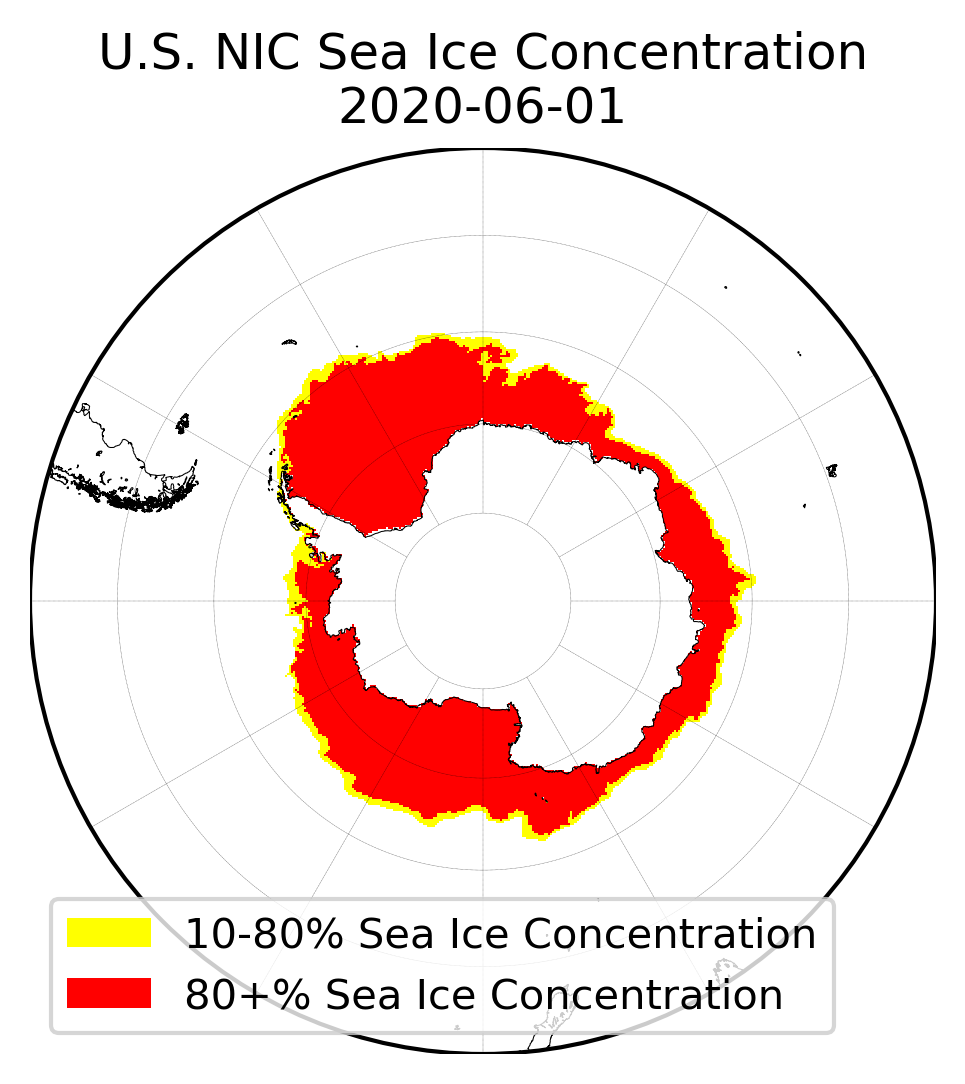

In [16]:
nic_arr = nic(end, nic_input_folder, hemi)
cdr_arr = cdr(end, cdr_input_folder, hemi)
_, local_cdr_name = datetime_to_cdr_fname(end, hemi)
metadata = get_cdr_metadata(os.path.join(cdr_input_folder, local_cdr_name))

fig, ax = plt.subplots(dpi=300)
m = Basemap(
    ax=ax,
    projection=proj, boundinglat=metadata['bounding_lat'], lon_0=metadata['lon_0'],
    resolution='i', round=True
)

m.drawcoastlines(linewidth=.25)
m.drawmeridians(np.arange(0, 360, 30), linewidth=.1)
m.drawparallels(np.arange(-90, 90, 10), linewidth=.1)

x, y = m(metadata['lons'], metadata['lats'])

cmap = mpl.colors.ListedColormap(["yellow", "red"])
norm = mpl.colors.BoundaryNorm([0, .7, 1], cmap.N) 

im = plt.imshow(np.ma.masked_where(nic_arr<=0, nic_arr), 
                cmap=cmap,
                norm=norm,
                extent=(x.max(), x.min(), y.max(), y.min()))
plt.legend([plt.Rectangle((0, 0), 1, .1, fc='yellow'), plt.Rectangle((0, 0), 1, .1, fc='red')],
                   ['10-80% Sea Ice Concentration', '80+% Sea Ice Concentration'], loc='lower left')

ax.set_title(f"U.S. NIC Sea Ice Concentration\n{end:%Y-%m-%d}")
plt.show()

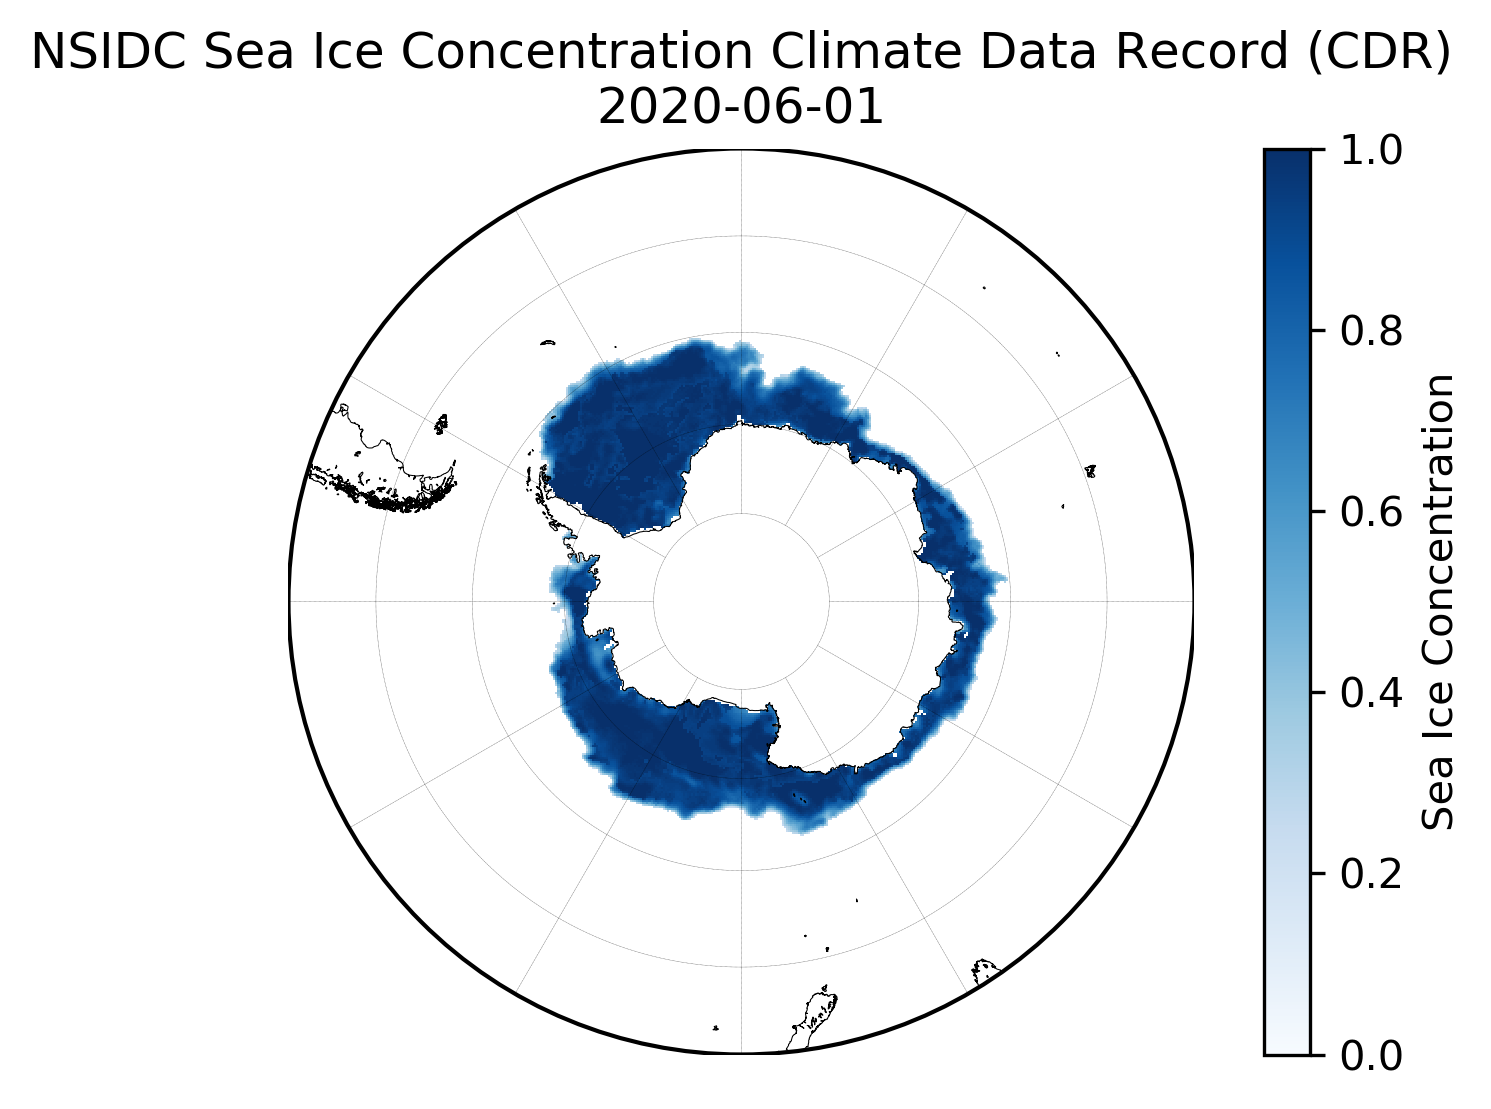

In [6]:
fig, ax = plt.subplots(dpi=300)
m = Basemap(
    ax=ax,
    projection=proj, boundinglat=metadata['bounding_lat'], lon_0=metadata['lon_0'],
    resolution='i', round=True
)

m.drawcoastlines(linewidth=.25)
m.drawmeridians(np.arange(0, 360, 30), linewidth=.1)
m.drawparallels(np.arange(-90, 90, 10), linewidth=.1)

x, y = m(metadata['lons'], metadata['lats'])

im = plt.imshow(np.ma.masked_where(cdr_arr<=0, cdr_arr), 
                cmap=plt.cm.Blues, 
                vmin=0, 
                vmax=1, 
                extent=(x.max(), x.min(), y.max(), y.min()))
cbar = plt.colorbar() 
cbar.set_label('Sea Ice Concentration')

ax.set_title(f"NSIDC Sea Ice Concentration Climate Data Record (CDR)\n{end:%Y-%m-%d}")
plt.show()

To compare the two datasets directly, I've simplified the CDR data to the two categories which are equivalent to the NIC data.  I compared the total area of sea ice contained within the 80% Sea Ice Concentration inner perimeter.  I also compared the total sea ice within the outer perimeters (15% and 10%).  I ran these comparisons for the last 2-3 years of data.

### Results
I noted several striking differences between the two representations of the Marginal Ice Zone.  As expected, the outer perimeter of the Marginal Ice Zone extends farther north in the NIC representation than the CDR representation.  However, the inner perimeter also follows the same trend – the NIC data shows this perimeter farther north than the CDR data.  Additionally, the CDR data consistently shows a greater total Marginal Ice Zone area than the NIC dataset due to the CDR inner perimeter being significantly farther south than the NIC inner perimeter.  The plot below shows the total area of ice within both the inner and outer boundaries of the Marginal Ice Zone for both products.  The cyan and magenta areas that are shaded between these two lines represents the total area of the Marginal Ice Zone.  

In [7]:
# To speed things up, only pull the lats/lons and metadata of the _first_ netcdf
# We'll do a shape check to make sure the shapes of the data match, but after this we'll assume the 
# lats/lons and metadata match in each netcdf.
cdr_fname = os.path.join(cdr_input_folder, datetime_to_cdr_fname(start, hemi)[1])
cdr_meta = get_cdr_metadata(cdr_fname)

# Outer threshold represents the minimum sea ice categorized as MIZ
# Inner threshold represents the maximum sea ice categorized as MIZ 
outer_nic_thresh = .1
inner_nic_thresh = .8

outer_cdr_thresh = .15
inner_cdr_thresh = .8

# We want to have individual time series for each year
# To capture the most interesting data in the center of the graph, have the left-side be at the mean minimum sea ice extent
year_delimeters = pd.date_range(start=start, end=end, freq='AS', closed="right")

# ~Feb 15 = minimum, 46 days into the year
offset_from_year_start = datetime.timedelta(days=46)

year_delimeters = [year + offset_from_year_start for year in year_delimeters]
dfs = []
for year_start in year_delimeters:
    year_end = year_start + pd.DateOffset(years=1)
    ice_areas = []
    df_columns = ['NIC inner extent', 'CDR inner extent', 'NIC outer extent', 'CDR outer extent']

    df = pd.DataFrame(columns=['date'] + df_columns)
    df.set_index('date', inplace=True)

    for day_analyzed in pd.date_range(start=year_start, end=year_end, closed="right"):
        cdr_file = os.path.join(cdr_input_folder, datetime_to_cdr_fname(day_analyzed, hemi)[1])
        nic_file = os.path.join(nic_input_folder, datetime_to_nic_fname(day_analyzed, hemi)[1])

        # We want to make sure both files exist.  If they don't, it's too late now.
        if not os.path.exists(cdr_file) or not os.path.exists(nic_file):
            continue

        try:
            cdr_area, nic_area = calculate_ice_area(cdr_file, 
                                                    nic_file, 
                                                    day_analyzed, 
                                                    inner_nic_thresh, 
                                                    1, 
                                                    inner_cdr_thresh, 
                                                    1, 
                                                    cdr_meta, 
                                                    clobber_output=True)
            df.at[day_analyzed, 'NIC inner extent'] = nic_area
            df.at[day_analyzed, 'CDR inner extent'] = cdr_area
            
            cdr_area, nic_area = calculate_ice_area(cdr_file, 
                                                    nic_file, 
                                                    day_analyzed, 
                                                    outer_nic_thresh, 
                                                    1, 
                                                    outer_cdr_thresh, 
                                                    1, 
                                                    cdr_meta, 
                                                    clobber_output=True)
            df.at[day_analyzed, 'NIC outer extent'] = nic_area
            df.at[day_analyzed, 'CDR outer extent'] = cdr_area
        except Exception as e:
            #print(f"Couldn't run {day_analyzed}; {e}")
            # Lets avoid output for now and just ignore any errors
            pass
    dfs.append(df)
            

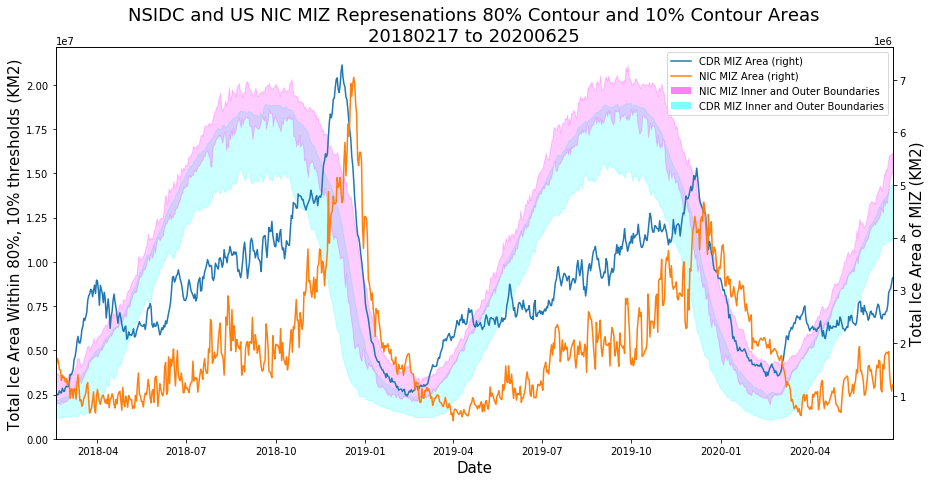

In [17]:
last_three_years_list = dfs[-3:]

last_three_years_df = pd.concat(last_three_years_list).fillna(value=0)

fig, ax = plt.subplots(figsize=(15,8))

colors = {'NIC': 'magenta', 'CDR': 'cyan'}
alpha = .2

last_three_years_df['CDR MIZ Area'] = last_three_years_df['CDR outer extent'] - last_three_years_df['CDR inner extent']
last_three_years_df['NIC MIZ Area'] = last_three_years_df['NIC outer extent'] - last_three_years_df['NIC inner extent']

ax.fill_between(last_three_years_df.index, 
                last_three_years_df['CDR inner extent'], 
                last_three_years_df['CDR outer extent'], 
                color=colors['CDR'], alpha=alpha)

ax.fill_between(last_three_years_df.index, 
                last_three_years_df['NIC inner extent'], 
                last_three_years_df['NIC outer extent'], 
                color=colors['NIC'], alpha=alpha)

ax2 = ax.twinx()
# It's easiest to reset the index for plotting
three_yrs_no_index = last_three_years_df.reset_index()
three_yrs_no_index.plot('date', ['CDR MIZ Area', 'NIC MIZ Area'], ax=ax2)

handles, labels = ax2.get_legend_handles_labels()

# Add labels indicating which axis this data is on
labels = [f"{i} (right)" for i in labels]
plt.legend(handles + [plt.Rectangle((0, 0), 1, .1, fc=color, alpha=.5) for color in colors.values()],
           labels + [f'{ds} MIZ Inner and Outer Boundaries' for ds in colors.keys()],
           loc='upper right')
ax.set_ylim(0)

# Avoid any space before or after the series
ax.margins(x=0)
ax.set_title("NSIDC and US NIC MIZ Represenations 80% Contour and 10% Contour Areas\n"
             f"{last_three_years_df.index.min():%Y%m%d} to {last_three_years_df.index.max():%Y%m%d}", size=18)
ax2.set_ylabel('Total Ice Area of MIZ (KM2)', size=15)
ax.set_ylabel('Total Ice Area Within 80%, 10% thresholds (KM2)', size=15)
ax.set_xlabel('Date', size=15)

ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,4))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-3,4))
plt.show()

Finally, I was interested in seeing what the longer-term relationship between these two sets of data looked like. I made a similar plot to the one above, except limited the x-axis to February 15th-February 15th and overlaid the 9 years of data I had access to. This result is consistent with my analysis of data from the shorter time period above - showing the NIC perimeters were consistently farther north than the CDR perimeters.

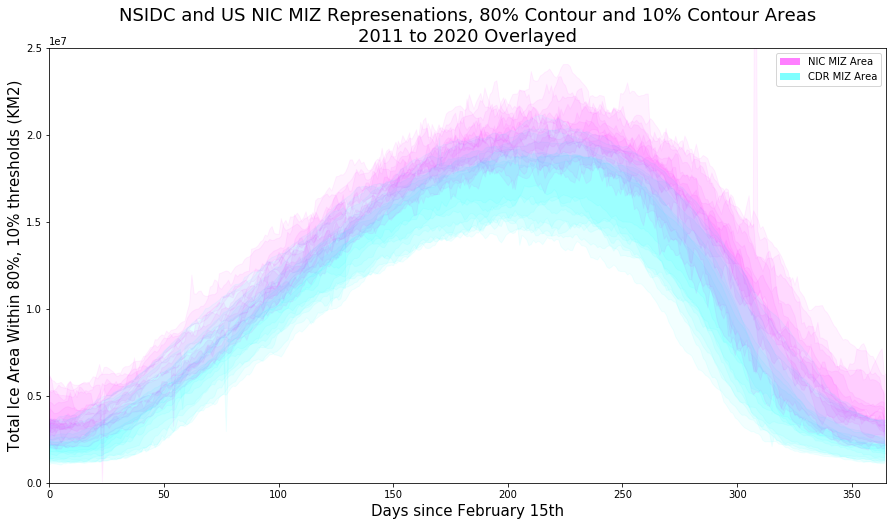

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
colors = {'NIC': 'magenta', 'CDR': 'cyan'}

alpha = .05
for df in dfs:
    df_filled = df.fillna(value=0)
    df_filled.index = (df_filled.index - df_filled.index[0]).days
    for ds in ['NIC', 'CDR']:
        ax.fill_between(df_filled.index.values, 
                        df_filled[f'{ds} inner extent'].values, 
                        df_filled[f'{ds} outer extent'].values, 
                        alpha=alpha, 
                        color=colors[ds])

plt.legend([plt.Rectangle((0, 0), 1, .1, fc=color, alpha=.5) for color in colors.values()],
           [f'{ds} MIZ Area' for ds in colors.keys()],
           loc='upper right')
ax.set_ylim(0, 2.5e7)
# Avoid any space before or after the series
ax.margins(x=0)
ax.set_title("NSIDC and US NIC MIZ Represenations, 80% Contour and 10% Contour Areas\n"
             f"{dfs[0].index.min():%Y} to {dfs[-1].index.min():%Y} Overlayed", size=18)
plt.xlabel('Days since February 15th', size=15)
plt.ylabel('Total Ice Area Within 80%, 10% thresholds (KM2)', size=15)
plt.show()

### Next Steps
I’m hoping to dive further into precisely what might be causing the differences noted above. I’m also interested in determining what percent Sea Ice Concentration in the CDR data represents the 80% Sea Ice Concentration in the NIC data. 

### How You Can Find Out More
To find out more about this project and re-run the entire workflow locally, visit the [github project](https://github.com/mikedorfman/NSIDC-MIZ-Comparison).  You can also find a description of the NSIDC dataset [here](https://nsidc.org/data/g02202) and the NIC dataset [here](https://www.natice.noaa.gov/daily_graphics.htm).